# Analisi dei risultati delle raccomandazioni
Questo notebook carica i file `.csv` presenti nella cartella `results/`, li unisce in un unico DataFrame e calcola alcune metriche di qualità (accuratezza globale, accuratezza per cluster, confusion matrix), visualizzando anche gli errori principali.


In [ ]:
import glob
import ast
import os
def in_top_k(row, k):
    preds = row['prediction_list']
    # se non è lista, trattiamola come lista vuota
    if not isinstance(preds, list):
        preds = []
    return row['ground_truth'] in preds[:k]

# funzione per parsing della colonna prediction
def safe_parse(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        return None

# Percorso ai file CSV
csv_files = glob.glob(os.path.join('results', '*.csv'))

In [ ]:

import pandas as pd

if not csv_files:
    raise FileNotFoundError('Non sono stati trovati file CSV nella cartella results/.')

# Caricamento e concatenazione
df_list = []
for f in csv_files:
    try:
        df_list.append(pd.read_csv(f))
    except Exception as e:
        print(f"Errore caricando {f}: {e}")
df = pd.concat(df_list, ignore_index=True)

# Parsing della colonna prediction (lista di stringhe -> lista)
df['prediction_list'] = df['prediction'].apply(safe_parse)

# Top‑1 prediction
df['pred_top1'] = df['prediction_list'].apply(lambda x: x[0] if isinstance(x, list) and x else None)

# Funzione per k=5 e k=10
df['hit_top5']  = df.apply(lambda r: in_top_k(r, 5),  axis=1)
df['hit_top10'] = df.apply(lambda r: in_top_k(r, 10), axis=1)

# Mostriamo le prime righe
#df.head()


In [ ]:

# Accuratezza globale (basata sul campo 'hit' booleano)
acc_top1  = df['hit'].mean()
acc_top5  = df['hit_top5'].mean()
acc_top10 = df['hit_top10'].mean()
print(f"Accuratezza globale Top-1:  {acc_top1:.2%}")
print(f"Accuratezza globale Top-5:  {acc_top5:.2%}")
print(f"Accuratezza globale Top-10: {acc_top10:.2%}")


Accuratezza globale Top-1:  16.23%
Accuratezza globale Top-5:  16.23%
Accuratezza globale Top-10: 16.23%


In [ ]:

# Accuratezza per cluster
cluster_metrics = df.groupby('cluster').agg(
    Top1  = ('hit',       'mean'),
    Top5  = ('hit_top5',  'mean'),
    Top10 = ('hit_top10', 'mean')
).sort_index()
display(cluster_metrics)


,Top1,Top5,Top10
cluster,,,
0,0.177505,0.177505,0.177505
1,0.219751,0.219751,0.219751
2,0.166937,0.166937,0.166937
3,0.157224,0.157224,0.157224
4,0.145304,0.145304,0.145304
5,0.043512,0.043512,0.043512
6,0.174194,0.174194,0.174194


In [ ]:

import pandas as pd
# Confusion matrix semplificata
cm = pd.crosstab(df['ground_truth'], df['pred_top1'], rownames=['Ground Truth'], colnames=['Predizione Top‑1'])

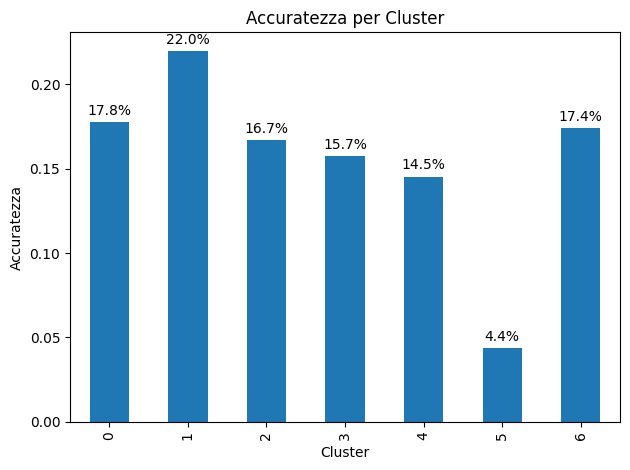

In [ ]:
import matplotlib.pyplot as plt

# Assicuriamoci di avere i cluster ordinati per ID
cluster_acc_sorted = cluster_acc.sort_index()

fig, ax = plt.subplots()
bars = cluster_acc_sorted.plot(kind='bar', ax=ax)

# Titoli e etichette
ax.set_xlabel('Cluster')
ax.set_ylabel('Accuratezza')
ax.set_title('Accuratezza per Cluster')

# Aggiungiamo le percentuali sopra le barre
for bar in bars.patches:
    height = bar.get_height()
    ax.annotate(f"{height:.1%}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # spostamento verticale in punti
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


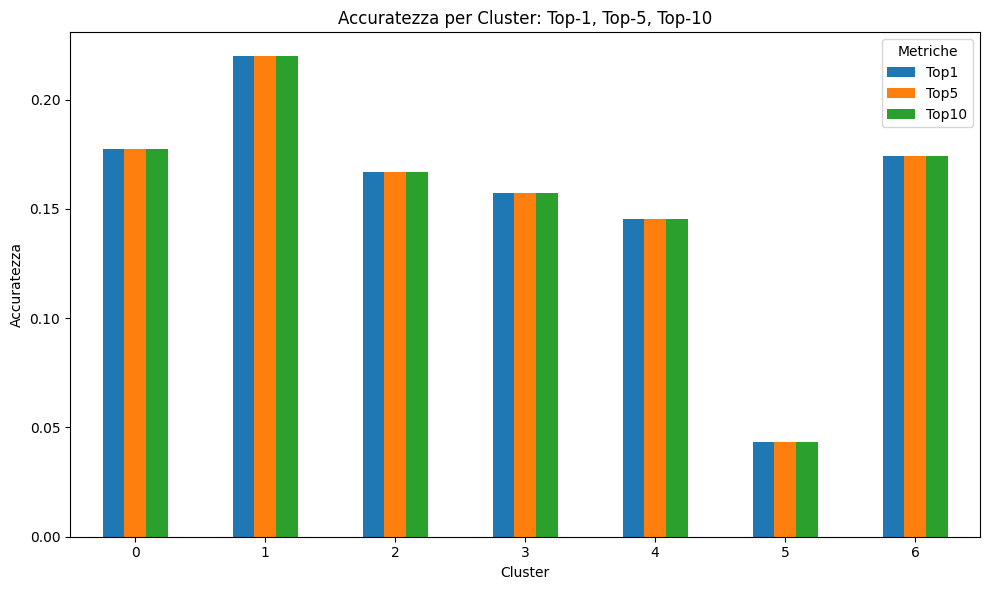

In [ ]:
import matplotlib.pyplot as plt

ax = cluster_metrics.plot(
    kind='bar', figsize=(10,6)
)
ax.set_xlabel('Cluster')
ax.set_ylabel('Accuratezza')
ax.set_title('Accuratezza per Cluster: Top-1, Top-5, Top-10')
ax.legend(title='Metriche')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()